### Importation des librairies :

In [1]:
## Pytorch - Pytorch Lightning
import torch 
import torch.nn as nn
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
import timm

## Métrique 
from torchmetrics import Accuracy

from tensorboardX import SummaryWriter

## Matrice de confusion
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix

## Gestion des données
#from data.MRIDataModule_Alexandre import MRIDataModule
from data.MRIDataModule_Romain import MRIDataModule

/Users/romain/miniforge3/envs/xAI/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Définition du modèle :

In [2]:
class MyModel(L.LightningModule):
    def __init__(self, 
                 lr: float = 0.001, 
                 weight_decay: float = 1e-4, 
                 num_class: int = 1, 
                 *args, 
                 **kwargs):
        
        super().__init__()
        self.save_hyperparameters()

        self.writer = SummaryWriter(log_dir='runs')

        ## Utilisation du modèle pré-entraîné ResNet50 et de la librairie Timm pour la gestion des images en noir et blanc (1 canal)
        #Le ResNet est modifié pour accepter des images en noir et blanc avec un seul canal (in_chans=1), ce qui est atypique, 
        # car la plupart des ResNet utilisent des images en trois canaux (RGB)
        self.model = timm.create_model(
            'resnet51q.ra2_in1k',  # version particulière du ResNet qui a été pré-entraînée sur un dataset comme ImageNet-1K ???
            pretrained=True,
            pretrained_cfg_overlay=dict(file='resnet51q.safetensors'), # permet de surcharger la config par défaut avec des paramètres spécifiques, 
            in_chans=1,
            num_classes=self.hparams.num_class,
        )
        
        ## Modification de la dernière couche pour une classification binaire
        in_features = self.model.get_classifier().in_features
        self.model.fc = nn.Linear(in_features, 1)
        
        ## Loss : BinaryCrossEntropy pour une classification binaire
        self.loss_train = nn.BCEWithLogitsLoss()
        self.loss_val = nn.BCEWithLogitsLoss()
        self.loss_test = nn.BCEWithLogitsLoss()
        
        ## Accuracy : pour la classification binaire
        self.train_acc = Accuracy(task="binary")
        self.valid_acc = Accuracy(task="binary")
        self.test_acc = Accuracy(task="binary")
        
        self.train_labels = []
        self.train_preds = []
 
    def forward(self, x):
        logits = self.model(x)
        # prédiction brute non bornée qui doit être transformée en probabilités avec une fonction comme la sigmoïde
        return logits
    
    def training_step(self, batch, batch_idx):
        # la précision est calculée après avoir appliqué une sigmoïde et un seuil de 0.5 (prob)
        x, y = batch
        x, y = x.to(self.device), y.to(self.device).float()  
        y_hat = self(x)
        loss = self.loss_train(y_hat.squeeze(), y)
        preds = torch.sigmoid(y_hat.squeeze()) >= 0.5  
        acc = self.train_acc(preds, y.int())
        self.writer.add_scalar('train/loss', loss.item(), self.global_step)
        self.writer.add_scalar('train/acc', acc.item(), self.global_step)
 
        self.train_labels.append(y.cpu())
        self.train_preds.append(preds.cpu())
        return loss
    
    # à la fin de chaque époque, les prédictions et les labels sont collectés, concaténés, et une matrice de confusion est calculée
    # pour observer les faux positifs/négatifs.
    def on_epoch_end(self):
        all_labels = torch.cat(self.train_labels)
        all_preds = torch.cat(self.train_preds)
        cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
        self.log_confusion_matrix(cm)
        self.train_labels = []
        self.train_preds = []
    
    # pareil que le train sauf que qu’il n’y a pas d’optimisation du modèle ici. Les pertes et précisions sont loguées pour évaluer la performance
    #  sur des données non vues.
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device).float()
        preds = self(x)
        loss = self.loss_val(preds.squeeze(), y)
        preds = torch.sigmoid(preds.squeeze()) >= 0.5
        acc = self.valid_acc(preds, y.int())
        self.writer.add_scalar('val/loss', loss.item(), self.global_step)
        self.writer.add_scalar('val/acc', acc.item(), self.global_step)
        return {'val_loss': loss}

    def test_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device).float()
        preds = self(x)
        loss = self.loss_test(preds.squeeze(), y)
        preds = torch.sigmoid(preds.squeeze()) >= 0.5
        acc = self.test_acc(preds, y.int())
        self.writer.add_scalar('test/loss', loss.item(), self.global_step)
        self.writer.add_scalar('test/acc', acc.item(), self.global_step)
        return {'test_loss': loss}
 
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)

In [3]:
checkpoint_callback = ModelCheckpoint(
    monitor="val/loss",
    dirpath="checkpoints3/",
    filename="best_model",
    save_top_k=1,
    mode="min",
)
early_stopping_callbak = EarlyStopping(
    monitor="val/loss",
    mode="min",
    patience=50,
    verbose=True
)
trainer = L.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callbak],
    max_epochs=500,
    accelerator='gpu',
    devices=1
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## train sur 1 époques version :

In [4]:
# Checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor="val/loss",
    dirpath="checkpoints3/",
    filename="best_model",
    save_top_k=1,
    mode="min",
)

# Early stopping callback
early_stopping_callback = EarlyStopping(
    monitor="val/loss",
    mode="min",
    patience=10, 
    verbose=True
)

# Définition du modèle
model = MyModel(lr=0.001, weight_decay=1e-4, num_class=1) # c'est bien 1 enfaite car c'est une classification binaire BCEWithLogitsLoss

# init du trainer avec seulement 2 époques
trainer = L.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=1,  # 1 époques
    accelerator='gpu',
    devices=1
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
model = MyModel()

In [10]:
print(model)

MyModel(
  (model): ByobNet(
    (stem): Stem(
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): ConvNormAct(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
      )
      (conv4): ConvNormAct(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
      )
    )
    (stages): Sequential(
      (0): Sequential(
        (0): BottleneckBlock(
          (shortcut): ConvNormAct(
            (conv): Co

In [8]:
# liste vide pour stocker les couches
layers_list = []

for layer in model.children(): # children affiches pas récursivement mais juste le premier niveau
    layers_list.append(layer)

for idx, layer in enumerate(layers_list):
    print(f"Layer {idx}: {layer}")

Layer 0: ByobNet(
  (stem): Stem(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv3): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
    )
    (conv4): ConvNormAct(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
    )
  )
  (stages): Sequential(
    (0): Sequential(
      (0): BottleneckBlock(
        (shortcut): ConvNormAct(
          (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [9]:
def print_layers_recursively(module, prefix=''):
    for name, layer in module.named_children():
        print(f"{prefix}Layer: {name}, {layer}")
        # Récursivement, explorer les sous-couches
        print_layers_recursively(layer, prefix + '  ')

# Appel de la fonction sur ton modèle
print_layers_recursively(model)

Layer: model, ByobNet(
  (stem): Stem(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv3): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
    )
    (conv4): ConvNormAct(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
    )
  )
  (stages): Sequential(
    (0): Sequential(
      (0): BottleneckBlock(
        (shortcut): ConvNormAct(
          (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

On dirait que dans la couche 0 tout le modèle ResNet50 pré-entraîné est encapsulé via timm.create_model()

### Chargement des données et répartion en train, val, test :

In [5]:
db_path = '../../../../data'
task = 'classification'
manifest = f'MRI_dataset_{task}.csv'

data = MRIDataModule(
    dataset_path=db_path,
    manifest_filename=manifest,
    batch_size=4,
    task=task,
    crop_size=None,
    train_val_test_shuffle=(True, False, False),
    train_val_test_split=(0.8,0.1,0.1),
    seed=23,
    verbose=True,
    normalization='max',
    num_workers=None,
)

trainset size: 800
validation size: 95
testset size: 105


#### Lien de téléchargement des données : https://www.kaggle.com/datasets/awsaf49/brats2020-training-data

## **Il faut modifier le fichier data/content/survival_info.csv, tu fais ctrl + f et tu cherches "ALIVE" et tu remplaces cette case par 360**

In [5]:
dataset_path = '/Volumes/Dock USB Stockage/Datasets/Brain Tumor Segmentation/BraTS2020_training_data/content/data'

# création du DataModule avec le seuil sur la survie
data_module = MRIDataModule(
    dataset_path=dataset_path,
    batch_size=4,
    #train_val_test_split=(0.8, 0.1, 0.1),  # 80% train, 10% val, 10% test
    train_val_test_split=(0.1, 0.1, 0.8), # 10% partout, c'est juste pour le test !
    seed=23  # seed pour la reproductibilité
)

# prépare les données (chargement des CSV et preparation des labels)
data_module.prepare_data()

# prépare les loaders (train, val, test)
data_module.setup()

# ptit test du train_dataloader
train_loader = data_module.train_dataloader()

#### Voilà les dimensions de mon train/val/test

In [27]:
for batch in train_loader:
    images, labels = batch

    # verif de la forme des images et labels
    print(f"Images shape: {images.shape}") 
    print(f"Images content: {images}")  #  contenu exact des images (valeurs)
    print(f"Labels shape: {labels.shape}") 
    print(f"Labels content: {labels}")  

    print(f"Type des images: {type(images)}")  # doit être torch.Tensor ?
    print(f"Type des labels: {type(labels)}")  # idem

    # si c pas int/float 
    if not torch.is_floating_point(labels):
        print("Converting labels to float")
        labels = labels.float()

    # s'arrête après un batch 
    break

/Users/romain/Documents/P_R_O_J_E_C_T_S/xAI/IAMedIm_explainability/data/MRIDataModule_Romain.py:71: RuntimeWarning: invalid value encountered in divide
  image = image / np.max(image)
/Users/romain/Documents/P_R_O_J_E_C_T_S/xAI/IAMedIm_explainability/data/MRIDataModule_Romain.py:71: RuntimeWarning: invalid value encountered in divide
  image = image / np.max(image)


Images shape: torch.Size([4, 1, 240, 240])
Images content: tensor([[[[-0.0341, -0.0341, -0.0341,  ..., -0.0341, -0.0341, -0.0341],
          [-0.0341, -0.0341, -0.0341,  ..., -0.0341, -0.0341, -0.0341],
          [-0.0341, -0.0341, -0.0341,  ..., -0.0341, -0.0341, -0.0341],
          ...,
          [-0.0341, -0.0341, -0.0341,  ..., -0.0341, -0.0341, -0.0341],
          [-0.0341, -0.0341, -0.0341,  ..., -0.0341, -0.0341, -0.0341],
          [-0.0341, -0.0341, -0.0341,  ..., -0.0341, -0.0341, -0.0341]]],


        [[[-0.1615, -0.1615, -0.1615,  ..., -0.1615, -0.1615, -0.1615],
          [-0.1615, -0.1615, -0.1615,  ..., -0.1615, -0.1615, -0.1615],
          [-0.1615, -0.1615, -0.1615,  ..., -0.1615, -0.1615, -0.1615],
          ...,
          [-0.1615, -0.1615, -0.1615,  ..., -0.1615, -0.1615, -0.1615],
          [-0.1615, -0.1615, -0.1615,  ..., -0.1615, -0.1615, -0.1615],
          [-0.1615, -0.1615, -0.1615,  ..., -0.1615, -0.1615, -0.1615]]],


        [[[-0.0998, -0.0998, -0.0998,  

/Users/romain/Documents/P_R_O_J_E_C_T_S/xAI/IAMedIm_explainability/data/MRIDataModule_Romain.py:71: RuntimeWarning: invalid value encountered in divide
  image = image / np.max(image)
/Users/romain/Documents/P_R_O_J_E_C_T_S/xAI/IAMedIm_explainability/data/MRIDataModule_Romain.py:71: RuntimeWarning: invalid value encountered in divide
  image = image / np.max(image)


#### affichage d'une image du dataset de train

/Users/romain/Documents/P_R_O_J_E_C_T_S/xAI/IAMedIm_explainability/data/MRIDataModule_Romain.py:40: RuntimeWarning: invalid value encountered in divide
  image = image / np.max(image)
/Users/romain/Documents/P_R_O_J_E_C_T_S/xAI/IAMedIm_explainability/data/MRIDataModule_Romain.py:40: RuntimeWarning: invalid value encountered in divide
  image = image / np.max(image)
/Users/romain/Documents/P_R_O_J_E_C_T_S/xAI/IAMedIm_explainability/data/MRIDataModule_Romain.py:40: RuntimeWarning: invalid value encountered in divide
  image = image / np.max(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016752383..1.0].


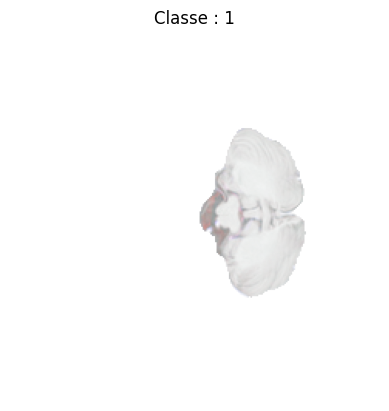

In [4]:
import matplotlib.pyplot as plt
import torch

# recup du premier batch du train_loader
train_loader = data_module.train_dataloader()
first_batch = next(iter(train_loader))

# split les images et les labels
images, labels = first_batch

# la première image et son label
first_image = images[0].squeeze(0)  #je vire le canal (1) pour l'affichage
first_label = labels[0].item()  # la classe de la première image

plt.imshow(first_image.cpu().numpy(), cmap='gray')
plt.title(f"Classe : {int(first_label)}")
plt.axis('off')
plt.show()

In [6]:
from tensorboardX import SummaryWriter

# Préparation des données
data_module.prepare_data()
data_module.setup()

# Init du trainer avec seulement 2 époques
trainer = L.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=2,  # Limité à 2 époques pour ce test
    accelerator='gpu',
    devices=1,
    logger=False  # desactivation du logger TensorBoard natif
)

# Lancement de l'entraînement du modèle
trainer.fit(model, datamodule=data_module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | model      | ByobNet           | 33.7 M | train
1 | loss_train | BCEWithLogitsLoss | 0      | train
2 | loss_val   | BCEWithLogitsLoss | 0      | train
3 | loss_test  | BCEWithLogitsLoss | 0      | train
4 | train_acc  | BinaryAccuracy    | 0      | train
5 | valid_acc  | BinaryAccuracy    | 0      | train
6 | test_acc   | BinaryAccuracy    | 0      | train
---------------------------------------------------------
33.7 M    Trainable params
0         Non-trainable params
33.7 M    Total params
134.607   Total estimated model params size (MB)
406       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/romain/miniforge3/envs/xAI/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/romain/miniforge3/envs/xAI/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|█████████▉| 914/915 [03:17<00:00,  4.63it/s]

ValueError: Target size (torch.Size([1])) must be the same as input size (torch.Size([]))

### Entraînement du modèle :

In [6]:
trainer.fit(model, data)

C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:652: Checkpoint directory C:\Users\M105411\Documents\IA_Med_Im\IA_Med_Im_PyTorch\Modèle1\Partie1 - GBM et RT conventionnelle\ResNet_classication_2classes\checkpoints3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


trainset size: 830
validation size: 110
testset size: 60



  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | model      | ByobNet           | 33.7 M | train
1 | loss_train | BCEWithLogitsLoss | 0      | train
2 | loss_val   | BCEWithLogitsLoss | 0      | train
3 | loss_test  | BCEWithLogitsLoss | 0      | train
4 | train_acc  | BinaryAccuracy    | 0      | train
5 | valid_acc  | BinaryAccuracy    | 0      | train
6 | test_acc   | BinaryAccuracy    | 0      | train
---------------------------------------------------------
33.7 M    Trainable params
0         Non-trainable params
33.7 M    Total params
134.607   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved. New best score: 0.569


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.038 >= min_delta = 0.0. New best score: 0.531


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.531


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

C:\Users\M105411\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [7]:
best_model_path = checkpoint_callback.best_model_path
best_model = MyModel.load_from_checkpoint(best_model_path)
best_model.eval()

C:\Users\M105411\Documents\IA_Med_Im\IA_Med_Im_PyTorch\Modèle1\Partie1 - GBM et RT conventionnelle\ResNet_classication_2classes\checkpoints3\best_model-v1.ckpt


MyModel(
  (model): ByobNet(
    (stem): Stem(
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): ConvNormAct(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
      )
      (conv4): ConvNormAct(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
      )
    )
    (stages): Sequential(
      (0): Sequential(
        (0): BottleneckBlock(
          (shortcut): ConvNormAct(
            (conv): Co

### Création de la matrice de confusion : 

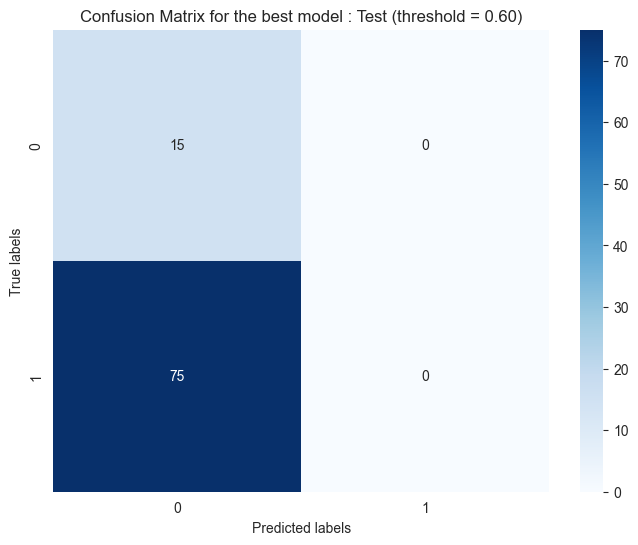

In [23]:
val_data = data.test_dataloader() 
 
val_labels = []
val_preds  = []
val_probs  = []  
 
with torch.no_grad():
    for batch in val_data:
        x, y = batch
        x, y = x.to(best_model.device), y.to(best_model.device)
        preds = best_model(x)
        val_labels.append(y.cpu())
        val_preds.append((torch.sigmoid(preds).squeeze() >= 0.60).cpu())
        val_probs.append(torch.sigmoid(preds).cpu())  

val_labels = torch.cat(val_labels)
val_preds  = torch.cat(val_preds)
val_probs  = torch.cat(val_probs)  
 
# Calculer et afficher la matrice de confusion
cm = confusion_matrix(val_labels, val_preds, labels=[0, 1])
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=[0, 1],
            yticklabels=[0, 1])
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for the best model : Test (threshold = 0.60)')
plt.savefig('best_model_confusion_matrix_test.png')
plt.show()